**Text prediction**

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import pickle
import numpy as np
import os

In [3]:
from google.colab import files
uploaded = files.upload()

Saving pg5200.txt to pg5200.txt


In [4]:
file = open("pg5200.txt", "r", encoding = "utf8")

# store file in list
lines = []
for i in file:
    lines.append(i)

# Convert list to string
data = ""
for i in lines:
  data = ' '. join(lines) 

#replace unnecessary stuff with space
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '').replace('“','').replace('”','')  #new line, carriage return, unicode character --> replace by space

#remove unnecessary spaces 
data = data.split()
data = ' '.join(data)
data[:500]

'The Project Gutenberg EBook of Metamorphosis, by Franz Kafka Translated by David Wyllie. This eBook is for the use of anyone anywhere at no cost and with almost no restrictions whatsoever. You may copy it, give it away or re-use it under the terms of the Project Gutenberg License included with this eBook or online at www.gutenberg.org ** This is a COPYRIGHTED Project Gutenberg eBook, Details Below ** ** Please follow the copyright guidelines in this file. ** Title: Metamorphosis Author: Franz Ka'

In [5]:
len(data)

138048

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])

# saving the tokenizer for predict function
pickle.dump(tokenizer, open('token.pkl', 'wb'))

sequence_data = tokenizer.texts_to_sequences([data])[0]
sequence_data[:15]

[1, 45, 43, 283, 5, 511, 55, 687, 688, 847, 55, 593, 594, 27, 283]

In [7]:
len(sequence_data)

25309

In [8]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

3068


In [9]:
sequences = []

for i in range(3, len(sequence_data)):
    words = sequence_data[i-3:i+1]
    sequences.append(words)
    
print("The Length of sequences are: ", len(sequences))
sequences = np.array(sequences)
sequences[:10]

The Length of sequences are:  25306


array([[  1,  45,  43, 283],
       [ 45,  43, 283,   5],
       [ 43, 283,   5, 511],
       [283,   5, 511,  55],
       [  5, 511,  55, 687],
       [511,  55, 687, 688],
       [ 55, 687, 688, 847],
       [687, 688, 847,  55],
       [688, 847,  55, 593],
       [847,  55, 593, 594]])

In [10]:
X = []
y = []

for i in sequences:
    X.append(i[0:3])
    y.append(i[3])
    
X = np.array(X)
y = np.array(y)

In [11]:
print("Data: ", X[:10])
print("Response: ", y[:10])

Data:  [[  1  45  43]
 [ 45  43 283]
 [ 43 283   5]
 [283   5 511]
 [  5 511  55]
 [511  55 687]
 [ 55 687 688]
 [687 688 847]
 [688 847  55]
 [847  55 593]]
Response:  [283   5 511  55 687 688 847  55 593 594]


In [12]:
y = to_categorical(y, num_classes=vocab_size)
y[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Creating the model

In [13]:
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=3))
model.add(LSTM(1000, return_sequences=True))
model.add(LSTM(1000))
model.add(Dense(1000, activation="relu"))
model.add(Dense(vocab_size, activation="softmax"))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 10)             30680     
                                                                 
 lstm (LSTM)                 (None, 3, 1000)           4044000   
                                                                 
 lstm_1 (LSTM)               (None, 1000)              8004000   
                                                                 
 dense (Dense)               (None, 1000)              1001000   
                                                                 
 dense_1 (Dense)             (None, 3068)              3071068   
                                                                 
Total params: 16,150,748
Trainable params: 16,150,748
Non-trainable params: 0
_________________________________________________________________


PLot the model 

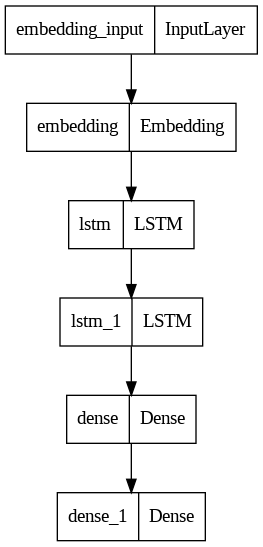

In [15]:
from tensorflow import keras
from keras.utils.vis_utils import plot_model

keras.utils.plot_model(model, to_file='plot.png', show_layer_names=True)

Build our model


In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("next_words.h5", monitor='loss', verbose=1, save_best_only=True)
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001))
model.fit(X, y, epochs=50, batch_size=64, callbacks=[checkpoint])

Epoch 1/50
396/396 [==============================] - ETA: 0s - loss: 6.4299
Epoch 1: loss improved from inf to 6.42995, saving model to next_words.h5
396/396 [==============================] - 271s 670ms/step - loss: 6.4299
Epoch 2/50
396/396 [==============================] - ETA: 0s - loss: 5.9913
Epoch 2: loss improved from 6.42995 to 5.99129, saving model to next_words.h5
396/396 [==============================] - 271s 686ms/step - loss: 5.9913
Epoch 3/50
396/396 [==============================] - ETA: 0s - loss: 5.6519
Epoch 3: loss improved from 5.99129 to 5.65194, saving model to next_words.h5
396/396 [==============================] - 276s 697ms/step - loss: 5.6519
Epoch 4/50
396/396 [==============================] - ETA: 0s - loss: 5.3161
Epoch 4: loss improved from 5.65194 to 5.31609, saving model to next_words.h5
396/396 [==============================] - 276s 698ms/step - loss: 5.3161
Epoch 5/50
396/396 [==============================] - ETA: 0s - loss: 5.0174
Epoch 5: lo

In [17]:
from tensorflow.keras.models import load_model
import numpy as np
import pickle

# Load the model and tokenizer
model = load_model('next_words.h5')
tokenizer = pickle.load(open('token.pkl', 'rb'))

def Predict_Next_Words(model, tokenizer, text):

  sequence = tokenizer.texts_to_sequences([text])
  sequence = np.array(sequence)
  preds = np.argmax(model.predict(sequence))
  predicted_word = ""
  
  for key, value in tokenizer.word_index.items():
      if value == preds:
          predicted_word = key
          break
  
  print(predicted_word)
  return predicted_word

In [18]:
while(True):
  text = input("Enter your line: ")
  
  if text == "0":
      print("Execution completed.....")
      break
  
  else:
      try:
          text = text.split(" ")
          text = text[-3:]
          print(text)
        
          Predict_Next_Words(model, tokenizer, text)
          
      except Exception as e:
        print("Error occurred: ",e)
        continue

Enter your line: The first thing he
['first', 'thing', 'he']
1/1 [==============================] - 1s 993ms/step
wanted
Enter your line:  This he managed quite 
['managed', 'quite', '']
1/1 [==============================] - 1s 1s/step
that
Enter your line: he let himself fall
['let', 'himself', 'fall']
1/1 [==============================] - 0s 43ms/step
against
Enter your line: the little legs would find a
['would', 'find', 'a']
1/1 [==============================] - 0s 45ms/step
use
Enter your line: For a moment everything remained
['moment', 'everything', 'remained']
1/1 [==============================] - 0s 42ms/step
quiet
Enter your line: "Gregor", said his father now from the room to his
['room', 'to', 'his']
1/1 [==============================] - 0s 53ms/step
left
Enter your line: his father impatiently, knocking
['father', 'impatiently,', 'knocking']
1/1 [==============================] - 0s 42ms/step
in
Enter your line: The chief clerk now raised
['clerk', 'now', 'raised']
1/

KeyboardInterrupt: ignored